In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import re
from pathlib import Path

from src.mitigation import train_adult_income_logreg_threshold,train_german_credit_logreg_threshold
from src.models import train_adult_income_baselines, train_german_credit_baselines
from src.data_loading import load_adult_income_dataset, load_german_credit_dataset
from src.fairness import metric_frame, fairness_summary_from_metric_frame

# Ensuring the output directory exists before writing any result tables or saving plots
# If results/ is missing, it will be created; if it already exists, nothing happens
RESULTS_DIR = Path("results")
PLOTS_DIR = RESULTS_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
def safe_filename(s: str) -> str:
    s = str(s).lower().strip()
    s = re.sub(r"[^\w\s-]", "", s)
    s = re.sub(r"[\s]+", "_", s)
    return s[:120]

def unique_path(base_path: Path) -> Path:
    # Avoiding overwriting: if file exists, add _2, _3, ...
    if not base_path.exists():
        return base_path
    stem = base_path.stem
    suffix = base_path.suffix
    i = 2
    while True:
        candidate = base_path.with_name(f"{stem}_{i}{suffix}")
        if not candidate.exists():
            return candidate
        i += 1

def save_plot(title: str, filename: str | None = None, dpi: int = 200):
    """
    Saving the current matplotlib figure to results/plots as PNG.
    """
    if filename is None:
        filename = safe_filename(title) or "plot"
        filename = filename + ".png"

    path = unique_path(PLOTS_DIR / filename)

    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    # marking current figure as already saved (prevents double-save if called twice)
    fig = plt.gcf()
    setattr(fig, "_autosave_done", True)

    print("Saved plot:", path.as_posix())


# auto save feature when plt.show() is called
_ORIGINAL_SHOW = plt.show  # keeping reference so it can be restored if needed
_PLOT_COUNTER = 0

def get_current_plot_title() -> str:
    fig = plt.gcf()

    # Trying suptitle first
    st = getattr(fig, "_suptitle", None)
    if st is not None and st.get_text().strip():
        return st.get_text().strip()

    # Fallback to first axes title
    axes = fig.get_axes()
    if axes and axes[0].get_title().strip():
        return axes[0].get_title().strip()

    return ""

def autosave_current_figure_if_needed():
    global _PLOT_COUNTER
    fig = plt.gcf()

    # If this figure was already saved, skip (prevents duplicates)
    if getattr(fig, "_autosave_done", False):
        return

    title = get_current_plot_title()
    if not title:
        _PLOT_COUNTER += 1
        title = f"plot_{_PLOT_COUNTER:03d}"

    save_plot(title)

def show(*args, **kwargs):
    # Saving before showing
    try:
        autosave_current_figure_if_needed()
    except Exception as e:
        print("WARNING: autosave failed:", e)

    return _ORIGINAL_SHOW(*args, **kwargs)

# Monkey-patch matplotlib show
plt.show = show
print("Autosave enabled: every plt.show() will also save a PNG to results/plots/")

Autosave enabled: every plt.show() will also save a PNG to results/plots/


In [3]:
# Loading the TEST splits for final evaluation of the threshold-optimized models
X_test_a, y_test_a, A_test_a, df_test_a = load_adult_income_dataset("test")
X_test_g, y_test_g, A_test_g, df_test_g = load_german_credit_dataset("test")

# Extracting protected attributes from the full test DataFrames
# These are used as sensitive_features for fairness evaluation and (later) for ThresholdOptimizer prediction
A_sex = df_test_a["sex"]
A_pss = df_test_g["sex"]


In [4]:
# Training the baseline model set for both datasets to compare
# a plain Logistic Regression baseline against the threshold-optimized (mitigated) version
adult_models = train_adult_income_baselines()
german_models = train_german_credit_baselines()

# Selecting the Logistic Regression baseline pipeline from the returned model dictionaries
adult_logreg = adult_models["logreg"]
german_logreg = german_models["logreg"]

# Generating baseline predictions on the TEST splits
y_pred_adult_base = adult_logreg.predict(X_test_a)
y_pred_german_base = german_logreg.predict(X_test_g)

# Computing performance + group fairness metrics for the baseline predictions
mf_adult_base = metric_frame(y_test_a, y_pred_adult_base, A_sex)
mf_german_base = metric_frame(y_test_g, y_pred_german_base, A_pss)

# Converting MetricFrame results into single-row summaries (for later comparison in a table/plot)
base_adult_row = fairness_summary_from_metric_frame(mf_adult_base, "logreg_baseline", "adult_income")
base_german_row = fairness_summary_from_metric_frame(mf_german_base, "logreg_baseline", "german_credit")


[Adult income] dummy: val accuracy = 0.751
[Adult income] logreg: val accuracy = 0.847
[Adult income] tree: val accuracy = 0.814
[Adult income] rf: val accuracy = 0.851
[Adult income] gb: val accuracy = 0.859
[German credit] dummy: val accuracy = 0.700
[German credit] logreg: val accuracy = 0.795
[German credit] tree: val accuracy = 0.720
[German credit] rf: val accuracy = 0.765
[German credit] gb: val accuracy = 0.760


In [5]:
# Training ThresholdOptimizer mitigations for Logistic Regression under the "equalized_odds" constraint
# ThresholdOptimizer is a post-processing method: it adjusts the decision threshold per group
# (learned on the validation split) to satisfy the fairness constraint as well as possible
adult_thresh_eo = train_adult_income_logreg_threshold(constraint="equalized_odds")
german_thresh_eo = train_german_credit_logreg_threshold(constraint="equalized_odds")

# ThresholdOptimizer predict needs sensitive_features
y_pred_adult_eo = adult_thresh_eo.predict(X_test_a, sensitive_features=A_sex)
y_pred_german_eo = german_thresh_eo.predict(X_test_g, sensitive_features=A_pss)

# Evaluating performance + group fairness metrics for the mitigated predictions
mf_adult_eo = metric_frame(y_test_a, y_pred_adult_eo, A_sex)
mf_german_eo = metric_frame(y_test_g, y_pred_german_eo, A_pss)

# Converting MetricFrame results into single-row summaries for comparison against the baseline
eo_adult_row = fairness_summary_from_metric_frame(mf_adult_eo, "logreg_thresh_equalized_odds", "adult_income")
eo_german_row = fairness_summary_from_metric_frame(mf_german_eo, "logreg_thresh_equalized_odds", "german_credit")


In [6]:
# ThresholdOptimizer with the "demographic_parity" constraint
# This is wrapped in a try/except because some constraint/predict_method combinations can fail depending
# on the data/model configuration
dp_adult_row, dp_german_row = None, None

try:
    # Training threshold optimizers (learn thresholds on validation split) for demographic parity
    adult_thresh_dp = train_adult_income_logreg_threshold(constraint="demographic_parity")
    german_thresh_dp = train_german_credit_logreg_threshold(constraint="demographic_parity")

    # ThresholdOptimizer needs sensitive_features at prediction time (group-specific thresholds)
    y_pred_adult_dp = adult_thresh_dp.predict(X_test_a, sensitive_features=A_sex)
    y_pred_german_dp = german_thresh_dp.predict(X_test_g, sensitive_features=A_pss)
    
    # Computing fairness/performance metrics for the thresholded predictions
    mf_adult_dp = metric_frame(y_test_a, y_pred_adult_dp, A_sex)
    mf_german_dp = metric_frame(y_test_g, y_pred_german_dp, A_pss)

    # Converting results into single-row summaries for later comparison
    dp_adult_row = fairness_summary_from_metric_frame(mf_adult_dp, "logreg_thresh_demographic_parity", "adult_income")
    dp_german_row = fairness_summary_from_metric_frame(mf_german_dp, "logreg_thresh_demographic_parity", "german_credit")
    
except Exception as e:
    print("DP thresholding skipped/failed:", e)


In [7]:
# Combining baseline and threshold-optimized summaries into comparison tables:
#   - baseline logistic regression
#   - equalized odds threshold-optimized logistic regression
# Including demographic parity thresholding only if it was successfully computed (dp_*_row not None)
rows_adult = [base_adult_row, eo_adult_row] + ([dp_adult_row] if dp_adult_row is not None else [])
rows_german = [base_german_row, eo_german_row] + ([dp_german_row] if dp_german_row is not None else [])

# Building DataFrames for easy display and saving
adult_thresh_compare = pd.DataFrame(rows_adult)
german_thresh_compare = pd.DataFrame(rows_german)

# Showing comparison tables in the notebook
display(adult_thresh_compare)
display(german_thresh_compare)

#Saving results
adult_thresh_compare.to_csv("results/adult_logreg_threshold_compare.csv", index=False)
german_thresh_compare.to_csv("results/german_logreg_threshold_compare.csv", index=False)

print("Saved: results/adult_logreg_threshold_compare.csv")
print("Saved: results/german_logreg_threshold_compare.csv")


,dataset,model,accuracy,precision,recall,f1,statistical_parity_diff,disparate_impact_ratio,equal_opportunity_diff,false_positive_rate_diff,average_odds_diff,predictive_parity_diff
0,adult_income,logreg_baseline,0.848207,0.733487,0.600270,0.660226,0.173951,0.325275,0.057805,0.076124,0.066965,0.013494
1,adult_income,logreg_thresh_equalized_odds,0.830876,0.697229,0.550811,0.615431,0.101372,0.553743,0.008035,0.009068,0.008551,0.262420
2,adult_income,logreg_thresh_demographic_parity,0.823838,0.685704,0.522432,0.593036,0.004339,0.977178,0.312809,0.057811,0.185310,0.322552


,dataset,model,accuracy,precision,recall,f1,statistical_parity_diff,disparate_impact_ratio,equal_opportunity_diff,false_positive_rate_diff,average_odds_diff,predictive_parity_diff
0,german_credit,logreg_baseline,0.705,0.787234,0.792857,0.790036,0.007143,0.989899,0.025,0.075,0.0500,0.069986
1,german_credit,logreg_thresh_equalized_odds,0.750,0.821429,0.821429,0.821429,0.023810,0.966330,0.100,0.200,0.1500,0.126879
2,german_credit,logreg_thresh_demographic_parity,0.735,0.827068,0.785714,0.805861,0.002381,0.996429,0.085,0.250,0.1675,0.145968


Saved: results/adult_logreg_threshold_compare.csv
Saved: results/german_logreg_threshold_compare.csv


Saved plot: results/plots/adult_income_thresholdoptimizer_trade-off_accuracy_vs_spd.png


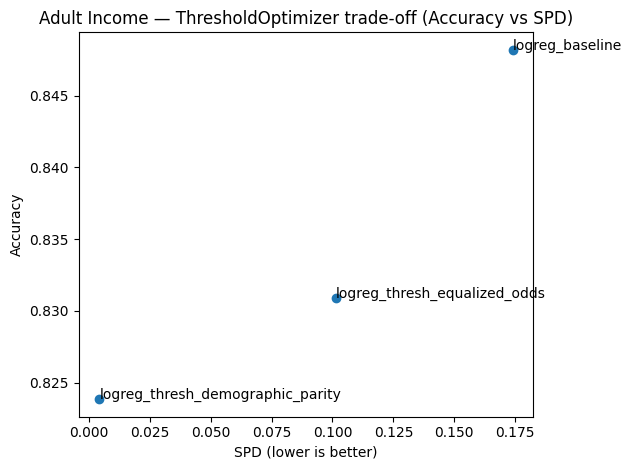

Saved plot: results/plots/adult_income_thresholdoptimizer_trade-off_accuracy_vs_average_odds_difference.png


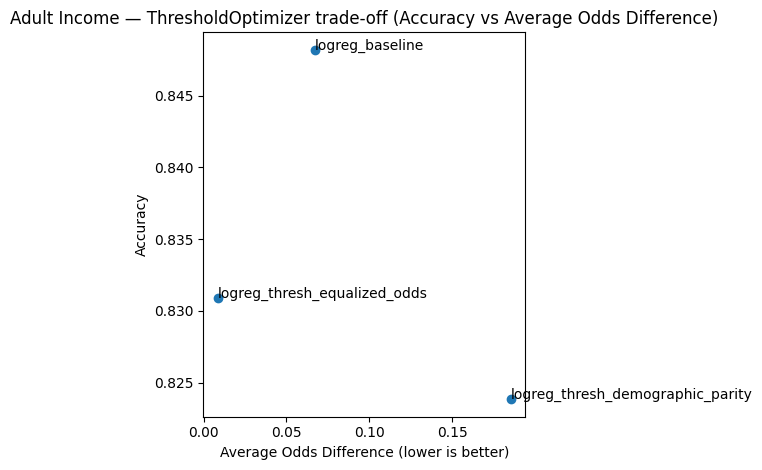

In [8]:
# Plotting the fairness–performance trade-off for Logistic Regression with ThresholdOptimizer mitigation (Adult Income)
# This compares:
#   - baseline logistic regression
#   - equalized_odds thresholding (and optionally demographic_parity thresholding if available)
# x-axis = Statistical Parity Difference (SPD): lower typically indicates less selection-rate disparity
# y-axis = Accuracy: higher indicates better predictive performance
df = adult_thresh_compare.copy()

plt.figure()
plt.scatter(df["statistical_parity_diff"], df["accuracy"])
for _, r in df.iterrows():
    plt.text(r["statistical_parity_diff"], r["accuracy"], r["model"])
plt.title("Adult Income — ThresholdOptimizer trade-off (Accuracy vs SPD)")
plt.xlabel("SPD (lower is better)")
plt.ylabel("Accuracy")
plt.show()

# Plotting the fairness–performance trade-off for ThresholdOptimizer using an equalized-odds style metric
# x-axis = Average Odds Difference (AOD): lower indicates smaller TPR/FPR disparities (closer to equalized odds)
# y-axis = Accuracy: higher indicates better predictive performance

plt.figure()
plt.scatter(df["average_odds_diff"], df["accuracy"])
for _, r in df.iterrows():
    plt.text(r["average_odds_diff"], r["accuracy"], r["model"])
plt.title("Adult Income — ThresholdOptimizer trade-off (Accuracy vs Average Odds Difference)")
plt.xlabel("Average Odds Difference (lower is better)")
plt.ylabel("Accuracy")
plt.show()
